In [ ]:
# import all neccesary libs
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# make sure random is the same for all users, then get the data
tf.random.set_seed(1)
np.random.seed(1)
(xTrain, yTrain), (xTest, yTest) = tf.keras.datasets.mnist.load_data()

# create flattened shape and normalize to greyscale
dim = 28
shape = dim**2
xTrain = xTrain.reshape(len(xTrain), shape).astype("float32") / 255.0
xTest = xTest.reshape(len(xTest), shape).astype("float32") / 255.0

In [ ]:
# define input layer, encoder part, and decoder part
inputMNIST = Input(shape=(shape,))
encoderNN = np.array([
                      Dense(392, activation='relu'),
                    #   Dense(128, activation='relu'), 
                    #   Dense(64, activation='relu'), 
                      Dense(2, activation='linear')])
decoderNN = np.array([
                    #   Dense(64, activation='relu'),
                    #   Dense(128, activation='relu'),
                      Dense(392, activation='relu'),
                      Dense(shape, activation='sigmoid')])

# connect the nn layers stored in array
def stack(NNArray, inputLayer):
    length = len(NNArray)

    layer = 0
    output = NNArray[layer](inputLayer) # first add the layer + input
    layer += 1 # move to next layer

    while layer < length:
        output = NNArray[layer](output) # add the previous to the next
        layer += 1 # move to next layer

    return output # we return the stacked NN with inputLayer


# put everything together
linkEncoderDecoder = np.concatenate((encoderNN, decoderNN))
stackedNN = stack(linkEncoderDecoder, inputMNIST)
autoencoder = Model(inputs=inputMNIST, outputs=stackedNN)

In [ ]:
# hyperparams and other things
learningRate = 1e-3
optimizer = tf.optimizers.Adam(learningRate)
loss = tf.losses.binary_crossentropy
epochs = 5
batchSize = 32
shuffle = True
validationData = (xTest, xTest)

# set hyperparams then train
autoencoder.compile(optimizer=optimizer, loss=loss)
autoencoder.fit(xTrain, xTrain,
                epochs=epochs,
                batch_size=batchSize,
                shuffle=shuffle,
                validation_data=validationData)

Epoch 1/5
1875/1875 [==============================] - 14s 7ms/step - loss: 0.2178 - val_loss: 0.1998
Epoch 2/5
1875/1875 [==============================] - 14s 7ms/step - loss: 0.1965 - val_loss: 0.1937
Epoch 3/5
1875/1875 [==============================] - 14s 7ms/step - loss: 0.1919 - val_loss: 0.1903
Epoch 4/5
1875/1875 [==============================] - 14s 7ms/step - loss: 0.1893 - val_loss: 0.1885
Epoch 5/5
1875/1875 [==============================] - 14s 7ms/step - loss: 0.1875 - val_loss: 0.1870


In [ ]:
# extract encoder
encoderOutput = stack(encoderNN, inputMNIST)
encoder = Model(inputs=inputMNIST, outputs=encoderOutput)

# extract decoder
encodedInput = Input(shape=(2,))
decoderOutput = stack(decoderNN, encodedInput)
decoder = Model(inputs=encodedInput, outputs=decoderOutput)

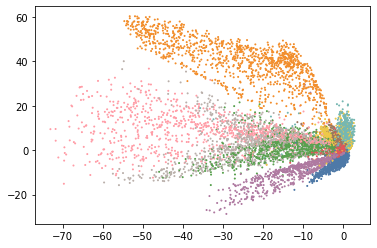

In [ ]:
# latent vector space
latent = encoder.predict(xTest)

# separate the coordinates into separate arrays for plotting
xs = []
ys = []
for coord in latent:
    [x,y] = coord
    xs.append(x)
    ys.append(y)

# Plot the points with corresponding color label
radius = 1
scheme = ["#4e79a7","#f28e2c","#e15759","#76b7b2","#59a14f","#edc949","#af7aa1","#ff9da7","#9c755f","#bab0ab"]
colors = []
for x, y, label in zip(xs, ys, yTest):
    num = int(label)
    colorMatch = scheme[num]
    colors.append(colorMatch)
plt.scatter(xs, ys, color=colors, s=radius)

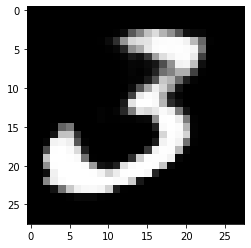

In [ ]:
# test one coordinate in the latent space
coord = [0,40]
img = decoder(np.array([coord]))
imgReshaped = np.array(img[0]).reshape(28,28)
plt.imshow(imgReshaped, cmap="gray")

In [ ]:
# set to True if you want to export to tensorflow js model
shouldExport = False
if shouldExport:
    svelteFilesFolder = "../svelte/public/datafiles"
    !pip3 install tensorflowjs
    import tensorflowjs as tfjs
    tfjs.converters.save_keras_model(encoder, f"{svelteFilesFolder}/encoder")
    tfjs.converters.save_keras_model(decoder, f"{svelteFilesFolder}/decoder")